In [53]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram
from math import pi


In [54]:
# Define a quantum circuit with 2 qubits: 1 address and 1 embedding
qc = QuantumCircuit(2)

# Apply Hadamard gate to the address qubit (qubit 0)
qc.h(0)

# Apply U1 (rotation around Z-axis) to the embedding qubit (qubit 1)
# Let's assume theta_1 = pi for this example
theta_1 = pi
qc.rz(theta_1, 1)

# For illustration, let's add a CNOT gate to create some entanglement
qc.cx(0, 1)

# Apply measurement to both qubits
qc.measure_all()

# Visualize the circuit
print("Quantum Circuit:")
print(qc.draw())


Quantum Circuit:
          ┌───┐        ░ ┌─┐   
   q_0: ──┤ H ├────■───░─┤M├───
        ┌─┴───┴─┐┌─┴─┐ ░ └╥┘┌─┐
   q_1: ┤ Rz(π) ├┤ X ├─░──╫─┤M├
        └───────┘└───┘ ░  ║ └╥┘
meas: 2/══════════════════╩══╩═
                          0  1 


Measurement Results:
{'00': 490, '11': 534}


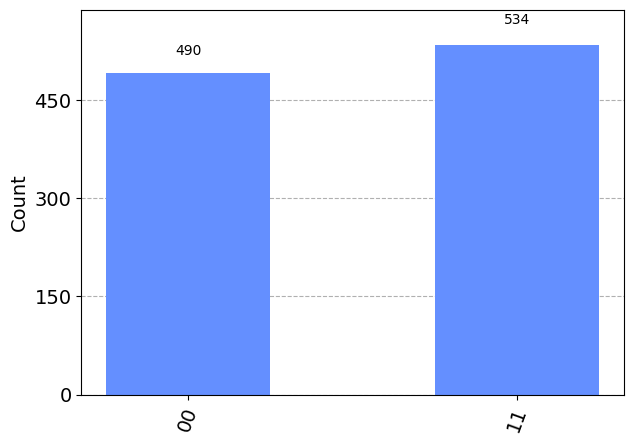

In [55]:
# Simulate the circuit
simulator = Aer.get_backend('qasm_simulator')
new_circuit = transpile(qc, simulator)
job = simulator.run(new_circuit)

# Plot the results
counts = job.result().get_counts(new_circuit)
print("Measurement Results:")
print(counts)
plot_histogram(counts)

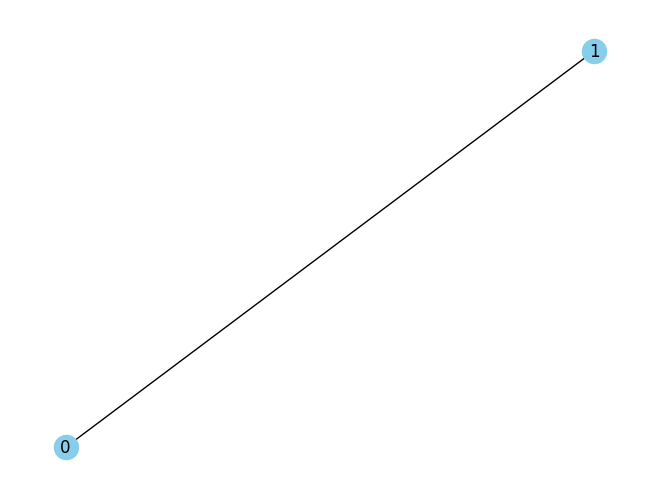

In [115]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Example adjacency matrix (replace this with your matrix)
A = np.array([[0, 1], [1, 0]])

# Create the graph from the adjacency matrix
G = nx.from_numpy_array(A)

# Draw the graph
nx.draw(G, with_labels=True, node_color='skyblue')
plt.show()


In [121]:
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram
from math import pi

# Parameters for the U gates
theta_values = [0, 0]  # Starting values for theta parameters
rotation_value = pi / 2
backend = Aer.get_backend('qasm_simulator')
num_iterations = 3  # Number of iterations to update parameters
delta = pi/10  # Small change to apply to theta for gradient approximation
learning_rate = 2  # Learning rate for gradient update
gamma = 0.8  # Example value for gamma, sets the penalty for wrongful node connection


# Assuming A is given
A = np.array([[0, 1], [1, 0]])  # Example adjacency matrix

# Define your quantum circuit as a function to easily recreate it with new theta values
def create_circuit(theta_values):
    qc = QuantumCircuit(3, 2)
    for i in range(2):
        qc.h(i)
    for i, t_val in enumerate(theta_values):
        qc.rz(t_val, 2)
        qc.cz(i, 2)  # Assuming the controlled-Z operation
    qc.x(1)
    qc.cx(0, 1)
    qc.cx(1, 2)
    for i in range(2):
        qc.ry(rotation_value, i)
    qc.measure([0,1], [0,1])
    return qc

print(qc.draw())

def calculate_gradient(A, theta_values, qc, backend, delta):
    gradients = []
    for i in range(len(theta_values)):
        # Create circuits for theta + delta and theta - delta
        theta_plus_delta = theta_values.copy()
        theta_plus_delta[i] += delta
        theta_minus_delta = theta_values.copy()
        theta_minus_delta[i] -= delta
        
        # Calculate objective for theta + delta
        qc_plus = create_circuit(theta_plus_delta)
        job_plus = backend.run(transpile(qc_plus, backend))
        L_plus = calculate_objective(A, job_plus.result().get_counts(qc_plus))
        
        # Calculate objective for theta - delta
        qc_minus = create_circuit(theta_minus_delta)
        job_minus = backend.run(transpile(qc_minus, backend))
        L_minus = calculate_objective(A, job_minus.result().get_counts(qc_minus))
        
        # Estimate gradient
        gradient = (L_plus - L_minus) / (2 * delta)
        gradients.append(gradient)
        
    return gradients

def calculate_objective(A, counts):

    L = 0
    # Assuming counts is a dict with keys '00', '01', '10', '11' for a 2-qubit system
    # Need to adapt this logic based on actual measurement mapping and problem size
    prob_00 = counts.get('00', 0) / sum(counts.values())
    prob_01 = counts.get('01', 0) / sum(counts.values())
    prob_10 = counts.get('10', 0) / sum(counts.values())
    prob_11 = counts.get('11', 0) / sum(counts.values())
    
    # Example calculation
    L += A[0, 1] * (prob_00 + prob_11) - gamma * (1 - A[0, 1]) * (prob_01 + prob_10)
    
    return L


for iteration in range(num_iterations):
    qc = create_circuit(theta_values)
    print(qc.draw())

    transpiled_qc = transpile(qc, backend)
    job = backend.run(transpiled_qc)
    result = job.result()
    counts = result.get_counts(qc)
    
    # Update theta_values based on calculated gradient
    gradients = calculate_gradient(A, theta_values, qc, backend, delta)
    theta_values = [theta - learning_rate * grad for theta, grad in zip(theta_values, gradients)]
    
    print(f"Iteration {iteration+1}: Theta values = {theta_values}")




           ┌───┐                                         ┌─────────┐           »
q_0: ──────┤ H ├────────■─────────────────────────────■──┤ Ry(π/2) ├───────────»
           ├───┤        │                      ┌───┐┌─┴─┐└─────────┘┌─────────┐»
q_1: ──────┤ H ├────────┼────────────────────■─┤ X ├┤ X ├─────■─────┤ Ry(π/2) ├»
     ┌─────┴───┴──────┐ │ ┌────────────────┐ │ └───┘└───┘   ┌─┴─┐   └─────────┘»
q_2: ┤ Rz(-0.0058594) ├─■─┤ Rz(-0.0073242) ├─■──────────────┤ X ├──────────────»
     └────────────────┘   └────────────────┘                └───┘              »
c: 2/══════════════════════════════════════════════════════════════════════════»
                                                                               »
«     ┌─┐   
«q_0: ┤M├───
«     └╥┘┌─┐
«q_1: ─╫─┤M├
«      ║ └╥┘
«q_2: ─╫──╫─
«      ║  ║ 
«c: 2/═╩══╩═
«      0  1 
       ┌───┐                           ┌─────────┐           ┌─┐   
q_0: ──┤ H ├───■────────────────────■──┤ Ry(π/2) ├───────────┤M├───
       ├───┤   │  

Measurement Results:
{'111 111 111 111 111 11': 259, '011 011 011 011 011 11': 263, '001 001 001 001 001 01': 272, '101 101 101 101 101 01': 230}


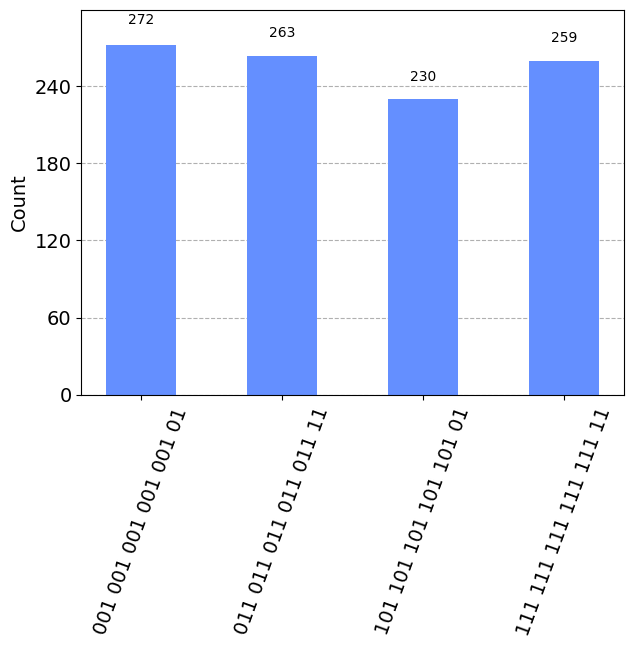

In [126]:
# Simulate the circuit
qc.measure_all()
simulator = Aer.get_backend('qasm_simulator')
new_circuit = transpile(qc, simulator)
job = simulator.run(new_circuit)

# Plot the results
counts = job.result().get_counts(new_circuit)
print("Measurement Results:")
print(counts)
plot_histogram(counts)